In [15]:
import math
import numpy as np

# -----------------------------
# Interval arithmetic utilities
# -----------------------------
# We use *outward rounding* with np.nextafter so the true value is guaranteed
# to stay inside [lo, hi] despite floating-point rounding.

def down(x: float) -> float:
    """Round x downward to the next representable float."""
    return np.nextafter(x, -np.inf)

def up(x: float) -> float:
    """Round x upward to the next representable float."""
    return np.nextafter(x, +np.inf)

class Interval:
    def __init__(self, lo: float, hi: float):
        if lo > hi:
            raise ValueError(f"Bad interval: [{lo}, {hi}]")
        self.lo = float(lo)
        self.hi = float(hi)

    def __repr__(self):
        return f"[{self.lo:.16g}, {self.hi:.16g}]"

    def width(self) -> float:
        return self.hi - self.lo

    def mid(self) -> float:
        return 0.5 * (self.lo + self.hi)

def iadd(a: Interval, b: Interval) -> Interval:
    return Interval(down(a.lo + b.lo), up(a.hi + b.hi))

def isub(a: Interval, b: Interval) -> Interval:
    return Interval(down(a.lo - b.hi), up(a.hi - b.lo))

def imul(a: Interval, b: Interval) -> Interval:
    # all endpoint products; take min/max with outward rounding
    p1 = a.lo * b.lo
    p2 = a.lo * b.hi
    p3 = a.hi * b.lo
    p4 = a.hi * b.hi
    lo = min(p1, p2, p3, p4)
    hi = max(p1, p2, p3, p4)
    return Interval(down(lo), up(hi))

def idiv(a: Interval, b: Interval) -> Interval:
    # Division is only well-defined if 0 is not in the denominator interval.
    if b.lo <= 0.0 <= b.hi:
        raise ZeroDivisionError(
            f"Denominator interval {b} contains 0. "
            "Newton step can blow up near where g'(x)=0; "
            "shrink the initial interval or split it."
        )
    # Multiply by reciprocal interval
    rlo = down(1.0 / b.hi)
    rhi = up(1.0 / b.lo)
    return imul(a, Interval(rlo, rhi))

def ipow_int(a: Interval, n: int) -> Interval:
    if n < 0:
        raise ValueError("Only nonnegative integer powers supported.")
    if n == 0:
        return Interval(1.0, 1.0)
    out = Interval(a.lo, a.hi)
    for _ in range(n - 1):
        out = imul(out, a)
    return out

# -----------------------------
# Problem definition
# g(x) = x^4 - 3x^3 - x + 3
# g'(x) = 4x^3 - 9x^2 - 1
# -----------------------------

def g_I(x: Interval) -> Interval:
    x2 = ipow_int(x, 2)
    x3 = imul(x2, x)
    x4 = imul(x3, x)

    term1 = x4
    term2 = imul(Interval(-3.0, -3.0), x3)
    term3 = imul(Interval(-1.0, -1.0), x)
    term4 = Interval(3.0, 3.0)

    return iadd(iadd(iadd(term1, term2), term3), term4)

def gp_I(x: Interval) -> Interval:
    x2 = ipow_int(x, 2)
    x3 = imul(x2, x)

    term1 = imul(Interval(4.0, 4.0), x3)
    term2 = imul(Interval(-9.0, -9.0), x2)
    term3 = Interval(-1.0, -1.0)

    return iadd(iadd(term1, term2), term3)

# -----------------------------
# Interval Newton iteration
# -----------------------------
# We explicitly model uncertainty at *each iteration* by maintaining x_k as
# an interval [lo, hi]. The update uses interval arithmetic:
#
#   x_{k+1} = x_k - g(x_k)/g'(x_k)
#
# Because the mapping is nonlinear, the interval can:
# - shrink if the Newton map is locally contracting in that region,
# - grow if it is locally expanding, or if g'(x) is small/changes sign,
# - change "shape" in the sense of widening/skewing due to nonlinearity.
#
# NOTE: A common refinement is the "interval Newton contractor" using a point
# m in X:  X_{new} = X ∩ (m - f(m)/f'(X)) which can contract more strongly.
# Below we implement the simpler propagate-through-iterations form requested.

def newton_interval_propagate(x0: Interval, max_iter: int = 15, verbose: bool = True):
    X = x0
    history = [X]
    if verbose:
        print("k | X_k (interval for x)                          | width(X_k)        | g(X_k)")
        print("--+----------------------------------------------+-------------------+------------------------------")
    for k in range(max_iter):
        GX = g_I(X)
        GpX = gp_I(X)

        # If derivative interval contains 0, the Newton step is not safe:
        # uncertainty can "explode" because dividing by near-zero slopes amplifies error.
        if GpX.lo <= 0.0 <= GpX.hi:
            raise ZeroDivisionError(
                f"At iteration {k}, g'(X_k) = {GpX} contains 0.\n"
                f"This indicates X_k overlaps a region where g'(x)=0, so the Newton step "
                f"can become unbounded.\n"
                f"Try a smaller initial interval or split X_k into sub-intervals and propagate each."
            )

        step = idiv(GX, GpX)   # interval for g/g'
        X_next = isub(X, step) # propagate uncertainty through the Newton map

        history.append(X_next)

        if verbose:
            print(f"{k:2d}| {X!r:<46} | {X.width():.16g} | {GX!r}")

        X = X_next

    return history

# -----------------------------
# Example usage (EDIT THESE)
# -----------------------------
# Choose a nominal initial guess x0_star and an uncertainty half-width Δ
x0_star = 1
Delta = 0.05
X0 = Interval(x0_star - Delta, x0_star + Delta)

hist = newton_interval_propagate(X0, max_iter=12, verbose=True)

print("\nFinal interval for root after iterations:", hist[-1])
print("Final width:", hist[-1].width())

k | X_k (interval for x)                          | width(X_k)        | g(X_k)
--+----------------------------------------------+-------------------+------------------------------
 0| [0.95, 1.05]                                   | 0.1000000000000001 | [-0.7083687500000041, 0.6933812500000035]


ZeroDivisionError: At iteration 1, g'(X_k) = [-12.06486409954064, 0.3378838782745064] contains 0.
This indicates X_k overlaps a region where g'(x)=0, so the Newton step can become unbounded.
Try a smaller initial interval or split X_k into sub-intervals and propagate each.

In [14]:
import numpy as np

# ============================================================
# Interval Newton setup (same as before, with the print fix)
# ============================================================

def down(x: float) -> float:
    return np.nextafter(x, -np.inf)

def up(x: float) -> float:
    return np.nextafter(x, +np.inf)

class Interval:
    def __init__(self, lo: float, hi: float):
        if lo > hi:
            raise ValueError(f"Bad interval: [{lo}, {hi}]")
        self.lo = float(lo)
        self.hi = float(hi)

    def __repr__(self):
        return f"[{self.lo:.16g}, {self.hi:.16g}]"

    def width(self) -> float:
        return self.hi - self.lo

    def mid(self) -> float:
        return 0.5 * (self.lo + self.hi)

def iadd(a: Interval, b: Interval) -> Interval:
    return Interval(down(a.lo + b.lo), up(a.hi + b.hi))

def isub(a: Interval, b: Interval) -> Interval:
    return Interval(down(a.lo - b.hi), up(a.hi - b.lo))

def imul(a: Interval, b: Interval) -> Interval:
    p1 = a.lo * b.lo
    p2 = a.lo * b.hi
    p3 = a.hi * b.lo
    p4 = a.hi * b.hi
    lo = min(p1, p2, p3, p4)
    hi = max(p1, p2, p3, p4)
    return Interval(down(lo), up(hi))

def idiv(a: Interval, b: Interval) -> Interval:
    if b.lo <= 0.0 <= b.hi:
        raise ZeroDivisionError(
            f"Denominator interval {b} contains 0 (g'(X) crosses 0). "
            "Shrink/split the interval."
        )
    rlo = down(1.0 / b.hi)
    rhi = up(1.0 / b.lo)
    return imul(a, Interval(rlo, rhi))

def ipow_int(a: Interval, n: int) -> Interval:
    if n < 0:
        raise ValueError("Only nonnegative integer powers supported.")
    if n == 0:
        return Interval(1.0, 1.0)
    out = Interval(a.lo, a.hi)
    for _ in range(n - 1):
        out = imul(out, a)
    return out

# g(x) = x^4 - 3x^3 - x + 3
# g'(x) = 4x^3 - 9x^2 - 1
def g_I(x: Interval) -> Interval:
    x2 = ipow_int(x, 2)
    x3 = imul(x2, x)
    x4 = imul(x3, x)
    return iadd(iadd(iadd(x4, imul(Interval(-3.0, -3.0), x3)),
                     imul(Interval(-1.0, -1.0), x)),
                Interval(3.0, 3.0))

def gp_I(x: Interval) -> Interval:
    x2 = ipow_int(x, 2)
    x3 = imul(x2, x)
    return iadd(iadd(imul(Interval(4.0, 4.0), x3),
                     imul(Interval(-9.0, -9.0), x2)),
                Interval(-1.0, -1.0))

def newton_interval_propagate_until(
    x0: Interval,
    max_iter: int = 50,
    x_tol: float = 1e-10,
    g_tol: float = 1e-10,
    verbose: bool = False,
):
    """
    Convergence definition (interval):
      - width(X_k) <= x_tol   AND
      - |g(mid(X_k))| <= g_tol

    Returns dict with status and history.
    """
    X = x0
    history = [X]

    if verbose:
        print("k | X_k                                   | width(X_k)         | g(mid(X_k))")
        print("--+----------------------------------------+--------------------+--------------------")

    for k in range(max_iter):
        # Track model residual at a representative point (midpoint)
        gmid = g_float(X.mid())

        if verbose:
            print(f"{k:2d}| {X!r:<40} | {X.width():<18.10e} | {abs(gmid):.10e}")

        # Check convergence (interval width + residual at midpoint)
        if (X.width() <= x_tol) and (abs(gmid) <= g_tol):
            return {"converged": True, "iters": k, "X": X, "history": history, "reason": "x_tol & g_tol"}

        GX = g_I(X)
        GpX = gp_I(X)

        # If derivative interval crosses 0, Newton step can blow up / become undefined
        if GpX.lo <= 0.0 <= GpX.hi:
            return {"converged": False, "iters": k, "X": X, "history": history,
                    "reason": "gprime interval crosses 0"}

        step = idiv(GX, GpX)
        X = isub(X, step)
        history.append(X)

    return {"converged": False, "iters": max_iter, "X": X, "history": history, "reason": "max_iter"}

# ============================================================
# Point Newton (for "which root" assessment inside the interval)
# ============================================================

def g_float(x: float) -> float:
    return x**4 - 3*x**3 - x + 3

def gp_float(x: float) -> float:
    return 4*x**3 - 9*x**2 - 1

def newton_point(x0: float, max_iter: int = 50, x_tol: float = 1e-12, g_tol: float = 1e-12):
    """
    Convergence definition (point):
      - |x_{k+1} - x_k| <= x_tol  AND
      - |g(x_{k+1})| <= g_tol
    """
    x = float(x0)
    for k in range(max_iter):
        gx = g_float(x)
        gpx = gp_float(x)
        if gpx == 0.0:
            return {"converged": False, "iters": k, "x": x, "reason": "gprime=0"}
        x_new = x - gx / gpx
        if (abs(x_new - x) <= x_tol) and (abs(g_float(x_new)) <= g_tol):
            return {"converged": True, "iters": k + 1, "x": x_new, "reason": "x_tol & g_tol"}
        x = x_new
    return {"converged": False, "iters": max_iter, "x": x, "reason": "max_iter"}

# Precompute the real roots of the polynomial once for classification
def real_roots_of_g():
    coeffs = [1.0, -3.0, 0.0, -1.0, 3.0]  # x^4 - 3x^3 + 0x^2 - x + 3
    r = np.roots(coeffs)
    real = [z.real for z in r if abs(z.imag) < 1e-10]
    real.sort()
    return np.array(real, dtype=float)

REAL_ROOTS = real_roots_of_g()

def classify_to_nearest_root(x: float) -> float:
    idx = int(np.argmin(np.abs(REAL_ROOTS - x)))
    return float(REAL_ROOTS[idx])

def roots_reached_within_interval(X0: Interval, n_seeds: int = 9):
    """
    Sample multiple starting points within X0, run point Newton,
    and report which real roots are reached (and if any seeds fail).
    """
    seeds = np.linspace(X0.lo, X0.hi, n_seeds)
    reached = []
    failures = 0
    for s in seeds:
        out = newton_point(s)
        if out["converged"]:
            reached.append(classify_to_nearest_root(out["x"]))
        else:
            failures += 1
    # cluster by rounding (avoid tiny float differences)
    reached = sorted(set([round(r, 12) for r in reached]))
    return {"roots": reached, "failures": failures, "n_seeds": n_seeds}

# ============================================================
# (c) Sensitivity study: systematically vary initial uncertainty
# ============================================================

def sensitivity_study(
    x0_star: float,
    deltas,
    max_iter_interval: int = 50,
    x_tol_interval: float = 1e-10,
    g_tol_interval: float = 1e-10,
    n_seeds: int = 11,
    verbose_each: bool = False,
):
    """
    For each Delta:
      - run interval Newton propagation and record iterations to convergence
      - estimate "which root" by sampling point Newton seeds within the interval
      - record final uncertainty (interval width)
    """
    rows = []

    for Delta in deltas:
        X0 = Interval(x0_star - Delta, x0_star + Delta)

        interval_out = newton_interval_propagate_until(
            X0,
            max_iter=max_iter_interval,
            x_tol=x_tol_interval,
            g_tol=g_tol_interval,
            verbose=verbose_each,
        )

        root_info = roots_reached_within_interval(X0, n_seeds=n_seeds)

        rows.append({
            "Delta": float(Delta),
            "X0": X0,
            "interval_converged": interval_out["converged"],
            "interval_iters": interval_out["iters"],
            "interval_reason": interval_out["reason"],
            "X_final": interval_out["X"],
            "final_width": interval_out["X"].width(),
            "roots_reached_by_point_newton": root_info["roots"],
            "point_newton_failures": root_info["failures"],
        })

    return rows

def print_sensitivity_table(rows):
    print("\nReal roots of g(x):", REAL_ROOTS)
    print("\nDelta        | interval conv | iters | final width     | roots reached (sampled)           | failures | note")
    print("-------------+---------------+-------+-----------------+----------------------------------+----------+------------------------------")
    for r in rows:
        note = r["interval_reason"]
        print(f"{r['Delta']:<12.3e} | {str(r['interval_converged']):<13} | {r['interval_iters']:<5} | "
              f"{r['final_width']:<15.3e} | {str(r['roots_reached_by_point_newton']):<32} | "
              f"{r['point_newton_failures']:<8} | {note}")

# ============================================================
# Example run (EDIT x0_star and the Delta sweep)
# ============================================================

x0_star = 0.5

# Sweep uncertainty magnitudes (systematic variation)
deltas = np.array([1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 5e-2, 1e-1], dtype=float)

rows = sensitivity_study(
    x0_star=x0_star,
    deltas=deltas,
    max_iter_interval=50,
    x_tol_interval=1e-10,
    g_tol_interval=1e-10,
    n_seeds=11,          # more seeds = better detection of basin boundaries
    verbose_each=False,
)

print_sensitivity_table(rows)



Real roots of g(x): [1. 3.]

Delta        | interval conv | iters | final width     | roots reached (sampled)           | failures | note
-------------+---------------+-------+-----------------+----------------------------------+----------+------------------------------
1.000e-06    | False         | 9     | 4.594e-01       | [1.0]                            | 0        | gprime interval crosses 0
1.000e-05    | False         | 7     | 3.967e-01       | [1.0]                            | 0        | gprime interval crosses 0
1.000e-04    | False         | 6     | 6.154e+00       | [1.0]                            | 0        | gprime interval crosses 0
1.000e-03    | False         | 4     | 2.299e+00       | [1.0]                            | 0        | gprime interval crosses 0
1.000e-02    | False         | 2     | 7.773e-01       | [1.0]                            | 0        | gprime interval crosses 0
5.000e-02    | False         | 1     | 6.047e-01       | [1.0]                     

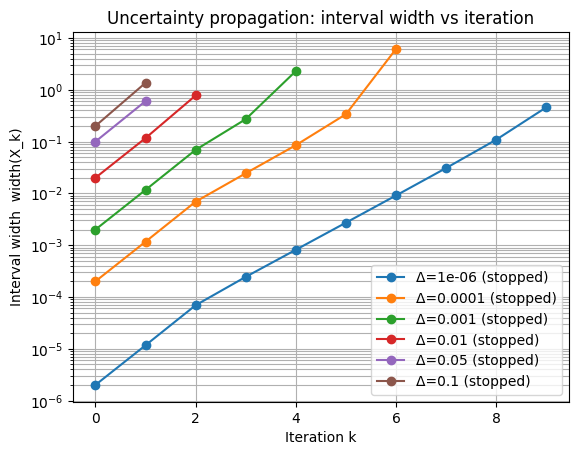

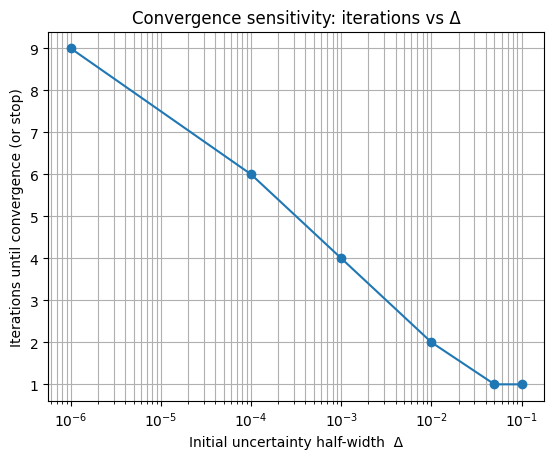

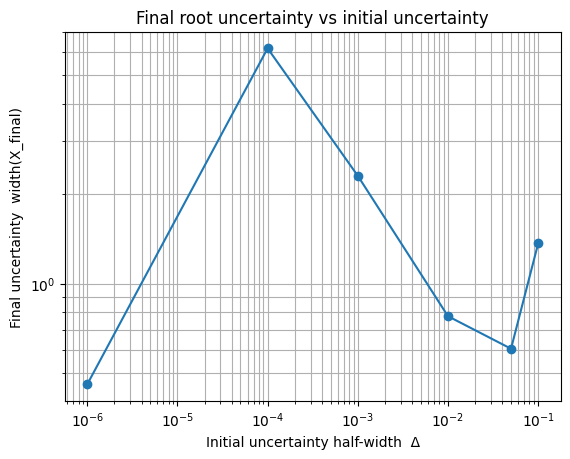

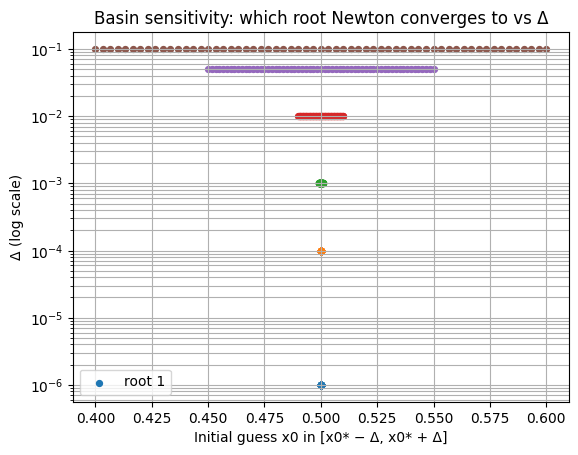

In [6]:
# ==========================================
# (d) Visualization of convergence and error
# NEW NOTEBOOK CELL (self-contained)
# ==========================================

import numpy as np
import matplotlib.pyplot as plt

# -----------------------------
# Interval arithmetic (outward)
# -----------------------------
def down(x: float) -> float:
    return np.nextafter(x, -np.inf)

def up(x: float) -> float:
    return np.nextafter(x, +np.inf)

class Interval:
    def __init__(self, lo: float, hi: float):
        if lo > hi:
            raise ValueError(f"Bad interval: [{lo}, {hi}]")
        self.lo = float(lo)
        self.hi = float(hi)

    def __repr__(self):
        return f"[{self.lo:.16g}, {self.hi:.16g}]"

    def width(self) -> float:
        return self.hi - self.lo

    def mid(self) -> float:
        return 0.5 * (self.lo + self.hi)

def iadd(a: Interval, b: Interval) -> Interval:
    return Interval(down(a.lo + b.lo), up(a.hi + b.hi))

def isub(a: Interval, b: Interval) -> Interval:
    return Interval(down(a.lo - b.hi), up(a.hi - b.lo))

def imul(a: Interval, b: Interval) -> Interval:
    p = [a.lo*b.lo, a.lo*b.hi, a.hi*b.lo, a.hi*b.hi]
    return Interval(down(min(p)), up(max(p)))

def idiv(a: Interval, b: Interval) -> Interval:
    if b.lo <= 0.0 <= b.hi:
        raise ZeroDivisionError(f"Denominator interval {b} contains 0.")
    r = Interval(down(1.0 / b.hi), up(1.0 / b.lo))
    return imul(a, r)

def ipow_int(a: Interval, n: int) -> Interval:
    if n < 0:
        raise ValueError("Only nonnegative integer powers supported.")
    if n == 0:
        return Interval(1.0, 1.0)
    out = Interval(a.lo, a.hi)
    for _ in range(n - 1):
        out = imul(out, a)
    return out

# -----------------------------
# Problem: g(x), g'(x)
# -----------------------------
def g_float(x: float) -> float:
    return x**4 - 3*x**3 - x + 3

def gp_float(x: float) -> float:
    return 4*x**3 - 9*x**2 - 1

def g_I(x: Interval) -> Interval:
    x2 = ipow_int(x, 2)
    x3 = imul(x2, x)
    x4 = imul(x3, x)
    return iadd(iadd(iadd(x4, imul(Interval(-3.0, -3.0), x3)),
                     imul(Interval(-1.0, -1.0), x)),
                Interval(3.0, 3.0))

def gp_I(x: Interval) -> Interval:
    x2 = ipow_int(x, 2)
    x3 = imul(x2, x)
    return iadd(iadd(imul(Interval(4.0, 4.0), x3),
                     imul(Interval(-9.0, -9.0), x2)),
                Interval(-1.0, -1.0))

# -----------------------------
# Interval Newton propagation (history)
# -----------------------------
def interval_newton_history(X0: Interval, max_iter: int = 30):
    """
    Propagate the *interval* through Newton's update:
        X_{k+1} = X_k - g(X_k)/g'(X_k)
    Stops early if g'(X_k) crosses 0 (step can become unbounded).
    """
    hist = [X0]
    X = X0
    stop_reason = None

    for _ in range(max_iter):
        GpX = gp_I(X)
        if GpX.lo <= 0.0 <= GpX.hi:
            stop_reason = "g'(X) crosses 0 (possible blow-up)"
            break
        step = idiv(g_I(X), GpX)
        X = isub(X, step)
        hist.append(X)

    return hist, stop_reason

def interval_converge_info(X0: Interval, max_iter=50, x_tol=1e-10, g_tol=1e-10):
    """
    Convergence definition (interval):
      width(X_k) <= x_tol  AND  |g(mid(X_k))| <= g_tol
    """
    hist, stop_reason = interval_newton_history(X0, max_iter=max_iter)
    for k, X in enumerate(hist):
        if (X.width() <= x_tol) and (abs(g_float(X.mid())) <= g_tol):
            return {"converged": True, "iters": k, "X_final": X, "reason": "x_tol & g_tol", "hist": hist}
    if stop_reason is not None:
        return {"converged": False, "iters": len(hist)-1, "X_final": hist[-1], "reason": stop_reason, "hist": hist}
    return {"converged": False, "iters": len(hist)-1, "X_final": hist[-1], "reason": "max_iter", "hist": hist}

# -----------------------------
# Point Newton (for root/basin plots)
# -----------------------------
def newton_point(x0: float, max_iter=50, x_tol=1e-12, g_tol=1e-12):
    x = float(x0)
    for k in range(max_iter):
        gx = g_float(x)
        gpx = gp_float(x)
        if gpx == 0.0:
            return {"converged": False, "iters": k, "x": x}
        x_new = x - gx / gpx
        if (abs(x_new - x) <= x_tol) and (abs(g_float(x_new)) <= g_tol):
            return {"converged": True, "iters": k+1, "x": x_new}
        x = x_new
    return {"converged": False, "iters": max_iter, "x": x}

# Precompute real roots for classification
REAL_ROOTS = np.array(sorted([z.real for z in np.roots([1, -3, 0, -1, 3]) if abs(z.imag) < 1e-10]))
def classify_to_nearest_root(x: float) -> float:
    return float(REAL_ROOTS[np.argmin(np.abs(REAL_ROOTS - x))])

# ==========================================
# USER CONTROLS (edit these)
# ==========================================
x0_star = 0.5
deltas = np.array([1e-6, 1e-4, 1e-3, 1e-2, 5e-2, 1e-1], dtype=float)
max_iter_plot = 25
n_seeds = 61  # more seeds = clearer basin boundary detection

# ==========================================
# Plot 1: Uncertainty evolution with iteration
# ==========================================
plt.figure()
for Delta in deltas:
    X0 = Interval(x0_star - Delta, x0_star + Delta)
    hist, stop_reason = interval_newton_history(X0, max_iter=max_iter_plot)
    widths = np.array([X.width() for X in hist], dtype=float)
    ks = np.arange(len(hist))
    plt.semilogy(ks, widths, marker="o", label=f"Δ={Delta:g}" + ("" if stop_reason is None else " (stopped)"))
plt.xlabel("Iteration k")
plt.ylabel("Interval width  width(X_k)")
plt.title("Uncertainty propagation: interval width vs iteration")
plt.grid(True, which="both")
plt.legend()
plt.show()

# ==========================================
# Plot 2: Convergence behavior vs initial uncertainty
# ==========================================
x_tol_interval = 1e-10
g_tol_interval = 1e-10
max_iter_interval = 50

iters = []
final_widths = []
converged = []

for Delta in deltas:
    X0 = Interval(x0_star - Delta, x0_star + Delta)
    out = interval_converge_info(X0, max_iter=max_iter_interval, x_tol=x_tol_interval, g_tol=g_tol_interval)
    iters.append(out["iters"])
    final_widths.append(out["X_final"].width())
    converged.append(out["converged"])

iters = np.array(iters, dtype=float)
final_widths = np.array(final_widths, dtype=float)

plt.figure()
plt.plot(deltas, iters, marker="o")
plt.xscale("log")
plt.xlabel("Initial uncertainty half-width  Δ")
plt.ylabel("Iterations until convergence (or stop)")
plt.title("Convergence sensitivity: iterations vs Δ")
plt.grid(True, which="both")
plt.show()

plt.figure()
plt.loglog(deltas, final_widths, marker="o")
plt.xlabel("Initial uncertainty half-width  Δ")
plt.ylabel("Final uncertainty  width(X_final)")
plt.title("Final root uncertainty vs initial uncertainty")
plt.grid(True, which="both")
plt.show()

# ==========================================
# Plot 3: Different roots / basin sensitivity
#   For each Δ, sample x0 across [x0*-Δ, x0*+Δ] and label which root is reached.
# ==========================================
root_labels = np.round(REAL_ROOTS, 10)
root_to_idx = {float(r): i for i, r in enumerate(root_labels)}

plt.figure()
for Delta in deltas:
    X0 = Interval(x0_star - Delta, x0_star + Delta)
    seeds = np.linspace(X0.lo, X0.hi, n_seeds)

    ridx = np.full_like(seeds, np.nan, dtype=float)
    for i, s in enumerate(seeds):
        out = newton_point(s)
        if out["converged"]:
            r = float(np.round(classify_to_nearest_root(out["x"]), 10))
            ridx[i] = root_to_idx[r]

    # plot each root index as its own band (marker shape only; no manual colors)
    for j, r in enumerate(root_labels):
        mask = (ridx == j)
        if np.any(mask):
            plt.scatter(seeds[mask], np.full(mask.sum(), Delta), s=18, marker="o",
                        label=f"root {r:g}" if Delta == deltas[0] else None)
    # failures
    fmask = np.isnan(ridx)
    if np.any(fmask):
        plt.scatter(seeds[fmask], np.full(fmask.sum(), Delta), s=24, marker="x",
                    label="fail" if Delta == deltas[0] else None)

plt.yscale("log")
plt.xlabel("Initial guess x0 in [x0* − Δ, x0* + Δ]")
plt.ylabel("Δ (log scale)")
plt.title("Basin sensitivity: which root Newton converges to vs Δ")
plt.grid(True, which="both")
plt.legend()
plt.show()

# # ==========================================
# # Short explanation text to paste into your writeup
# # ==========================================
# print(
# """Why these plots work:
# 1) width(X_k) vs k directly shows uncertainty amplification/attenuation per iteration.
#    Semilog-y makes contraction (often near-exponential) and sudden growth easy to see.
# 2) iterations-to-converge vs Δ shows how larger initial uncertainty slows or prevents convergence
#    (and can trigger g'(X) crossing 0, where the Newton step becomes unstable).
# 3) the basin plot reveals when the uncertain initial interval spans multiple basins of attraction:
#    different seeds inside the same [x0*−Δ, x0*+Δ] converging to different roots is a clear
#    diagnostic of sensitivity to initial conditions."""
# )
